In [12]:
import numpy as np
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Preprocessing

In [6]:
data_path = '/content/drive/MyDrive/Teeth DataSet/Teeth_Dataset'
train_path = '/content/drive/MyDrive/Teeth DataSet/Teeth_Dataset/Training'
val_path = '/content/drive/MyDrive/Teeth DataSet/Teeth_Dataset/Validation'
test_path = '/content/drive/MyDrive/Teeth DataSet/Teeth_Dataset/Testing'

img_size = 256
batch_size = 32

train_og = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

val_og = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

test_og = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

normalization = layers.Rescaling(1./255)
train_set = train_og.map(lambda x, y: (normalization(x), y))
val_set = val_og.map(lambda x, y: (normalization(x), y))
test_set = test_og.map(lambda x, y: (normalization(x), y))

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])
train_set = train_set.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


# Visualization

## Before and After Augmentation

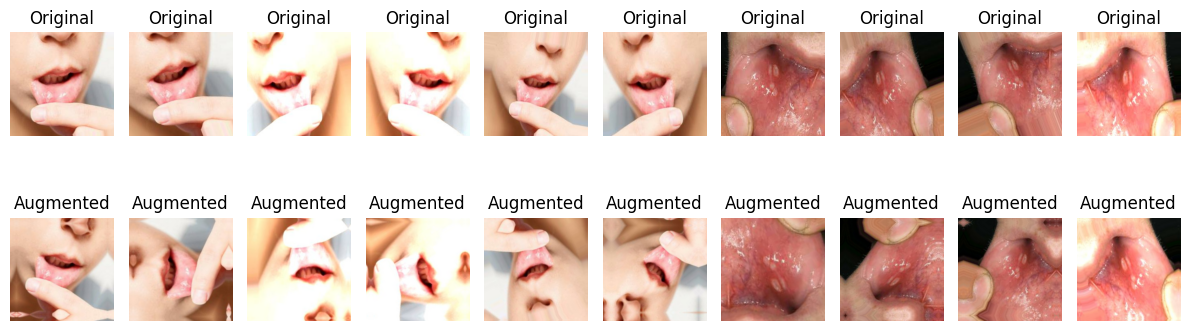

In [4]:
for og_images,_ in train_og.take(1):
  og_images = og_images.numpy() / 255.0
  break

for aug_images,_ in train_set.take(1):
  aug_images = aug_images.numpy()
  break

plt.figure(figsize=(12,6))

for i in range(10):
  plt.subplot(3,10,i+1)
  plt.imshow(og_images[i])
  plt.title('Original')
  plt.axis('off')

  plt.subplot(3,10,i+11)
  plt.imshow(aug_images[i])
  plt.title('Augmented')
  plt.axis('off')

plt.tight_layout()
plt.show()

## Classes Distribution

In [15]:
class_names = train_og.class_names
print(class_names)

train_counts = {}
val_counts = {}
test_counts = {}
train_dist = {}
val_dist = {}
test_dist = {}

for _,labels in train_og:
  for label in labels.numpy():
    label_value = np.argmax(label)
    if label_value not in train_counts:
      train_counts[label_value] = 1
    else:
      train_counts[label_value] += 1

for i,count in train_counts.items():
  class_name = class_names[i]
  train_dist[class_name] = count

for _,labels in val_og:
  for label in labels.numpy():
    label_value = np.argmax(label)
    if label_value not in val_counts:
      val_counts[label_value] = 1
    else:
      val_counts[label_value] += 1

for i,count in val_counts.items():
  class_name = class_names[i]
  val_dist[class_name] = count


for _,labels in test_og:
  for label in labels.numpy():
    label_value = np.argmax(label)
    if label_value not in test_counts:
      test_counts[label_value] = 1
    else:
      test_counts[label_value] += 1

for i,count in test_counts.items():
  class_name = class_names[i]
  test_dist[class_name] = count


print("Training Distribution: " ,train_dist)
print("Validation Distribution: " ,val_dist)
print("Testing Distribution: " ,test_dist)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Training Distribution:  {'OC': 324, 'CaS': 480, 'OLP': 540, 'MC': 540, 'Gum': 360, 'CoS': 450, 'OT': 393}
Validation Distribution:  {'CoS': 149, 'CaS': 160, 'Gum': 120, 'OLP': 180, 'MC': 180, 'OC': 108, 'OT': 131}
Testing Distribution:  {'MC': 180, 'OLP': 180, 'CaS': 160, 'Gum': 120, 'OT': 131, 'CoS': 149, 'OC': 108}


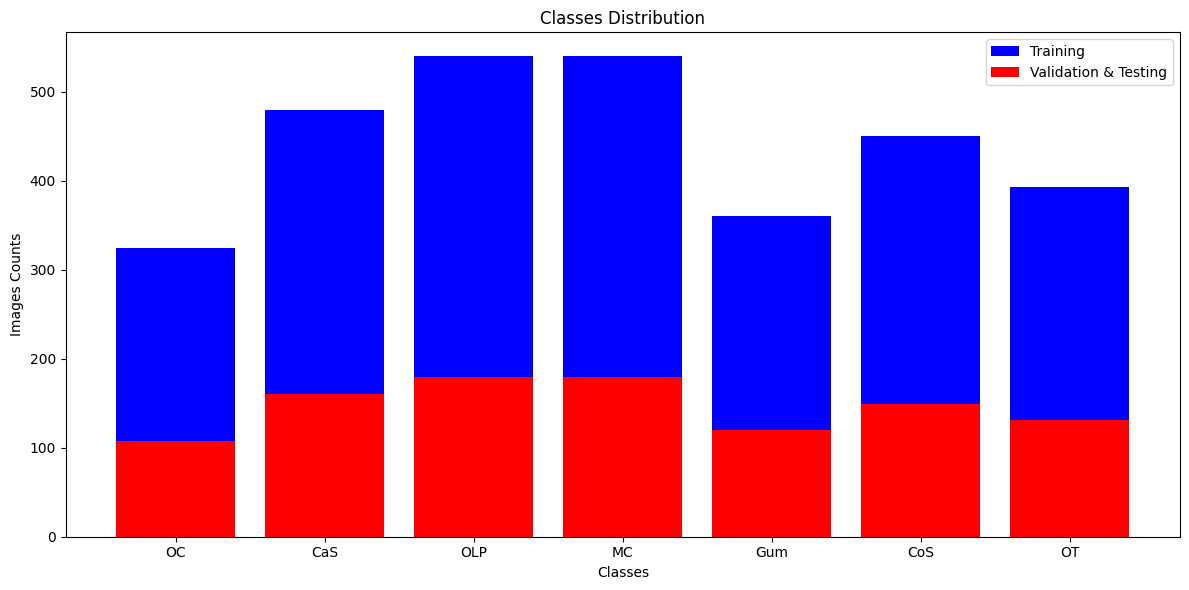

In [16]:
plt.figure(figsize=(12,6))
plt.bar(train_dist.keys(), train_dist.values(), label='Training', color='blue')
plt.bar(val_dist.keys(), val_dist.values(), label='Validation & Testing', color='red')
plt.xlabel('Classes')
plt.ylabel('Images Counts')
plt.title('Classes Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Model Architecture and Training

In [10]:
model = Sequential([
    Input(shape=(img_size, img_size, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')

])

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_set, validation_data=val_set, epochs=30, batch_size=32)

model.evaluate(test_set)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - accuracy: 0.1943 - loss: 2.1229 - val_accuracy: 0.2831 - val_loss: 1.7976
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 58s 594ms/step - accuracy: 0.2926 - loss: 1.7768 - val_accuracy: 0.3084 - val_loss: 1.7325
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 620ms/step - accuracy: 0.3436 - loss: 1.6364 - val_accuracy: 0.4377 - val_loss: 1.5288
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 600ms/step - accuracy: 0.3975 - loss: 1.5546 - val_accuracy: 0.4601 - val_loss: 1.4527
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 58s 590ms/step - accuracy: 0.4348 - loss: 1.4710 - val_accuracy: 0.4348 - val_loss: 1.4244
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - accuracy: 0.4513 - loss: 1.4255 - val_accuracy: 0.4825 - val_loss: 1.3475
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 58s 589ms/step - accuracy: 0.4770 - loss: 1.3513 - val_accuracy: 0.4951 - val_loss: 1.3557
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 589ms/step - accuracy: 0.4891 - loss: 1.3459 - val_accura

[0.647655725479126, 0.768482506275177]

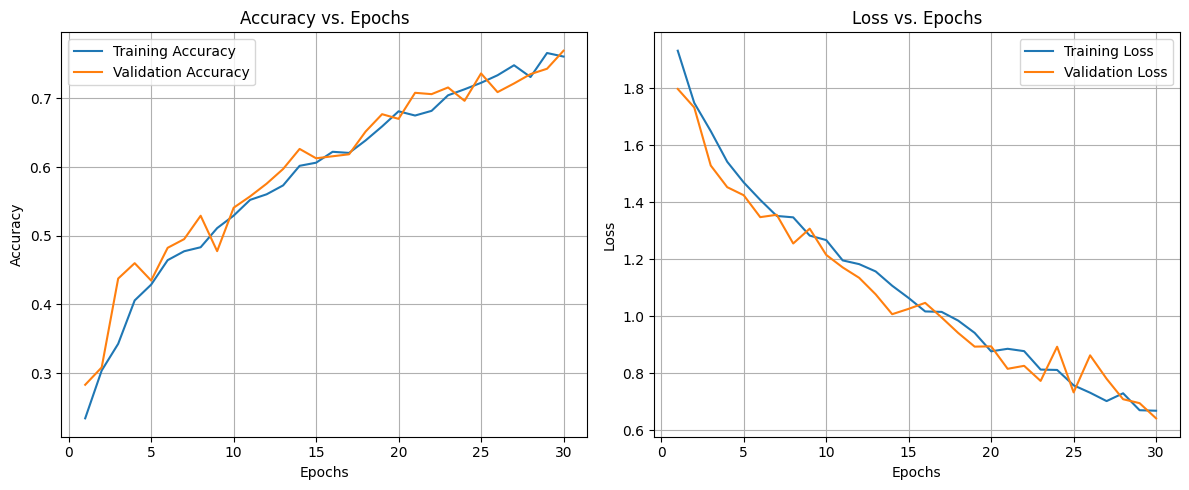

In [11]:
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [23]:
y_true = []
y_pred = []

for images, labels in test_set:
    predictions = model.predict(images,verbose=0)
    predicted_classes = tf.argmax(predictions, axis=1)
    true_labels = tf.argmax(labels, axis=1)
    y_true.extend(true_labels.numpy())
    y_pred.extend(predicted_classes.numpy())


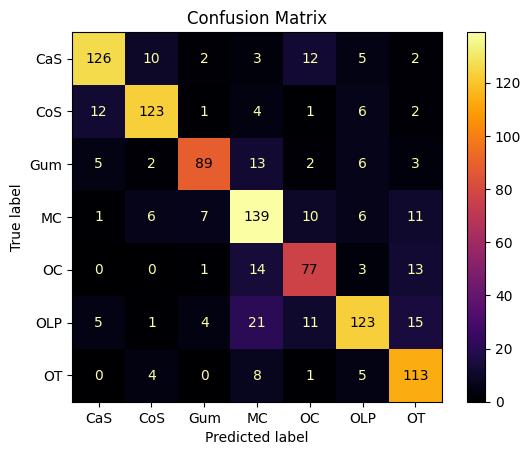

In [34]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.inferno, values_format='d')

plt.title('Confusion Matrix')
plt.show()